# Exploratory Data Analysis (EDA)

## The objectives of the EDA are:

1. Get a direct impression of the dataset, including the number of samples, features and their types.
2. Check the distribution of each feature, transform them to be more Gaussian-like if necessary.
3. Consider and eliminate the scale effects of features.
4. Explore the relationships between features, especially features within the same type: contamination, habitat, taxa.

## 1. Get a direct imporession of the dataset

Read in the data and check the different variable blocks.

In [1]:
import pandas as pd
from zci.data_process.dataframe_ops import get_block, concat_blocks
# read the contacted data set
data = pd.read_excel("../data/processed/complete_env_taxa_chemical.xlsx",
                     sheet_name="all_data_merged",
                     header=[0,1,2],
                     index_col=0)

# Remove multi-index levels from columns
raw_data = data.copy()
raw_data.columns = raw_data.columns.droplevel([0, 1])

data.head()

block     sample_info                           environmental            \
subblock          raw                                     raw             
var          Latitude Longitude Waterbody  Year       LOI (%) MPS (Phi)   
StationID                                                                 
A10          42.90455 -82.46760       SCR  2004      3.436193  1.734259   
A23          42.56658 -82.57595       LSC  2004      3.226637  1.969984   
A27          42.56007 -82.42132       LSC  2004      2.802642  1.319519   
A28          42.54577 -82.42073       LSC  2004      3.201399  1.398687   
A29          42.51440 -82.43462       LSC  2004      6.180718  1.065748   

block                                                                      \
subblock                                                                    
var       Measured Depth (m) Temperature (oC) Velocity  at bottom (m/sec)   
StationID                                                                   
A10                      1.8            19.17                         NaN   
A23                      3.0            19.10                         NaN   
A27                      1.0            18.40                         NaN   
A28                      0.5            18.90                         NaN   
A29                      0.5            19.30                         NaN   

block                             ...           taxa                          \
subblock                          ...            raw                           
var       Water DO Bottom (mg/L)  ... Hydropsychidae      Hydrozoa  Nematoda   
StationID                         ...                                          
A10                        10.21  ...   3.203427e-16  3.203427e-16  1.727234   
A23                        10.09  ...   3.203427e-16  3.203427e-16  2.427993   
A27                        10.30  ...   3.203427e-16  3.203427e-16  1.802219   
A28                        12.80  ...   3.203427e-16  3.203427e-16  2.771800   
A29                         9.70  ...   3.203427e-16  3.203427e-16  4.616441   

block                                                                \
subblock                                                              
var       Oligochaeta Other Trichoptera   Sphaeriidae   Turbellaria   
StationID                                                             
A10          6.576942      3.203427e-16  3.203427e-16  3.203427e-16   
A23          5.872905      3.203427e-16  1.022139e+00  5.997595e-01   
A27          6.402280      1.580169e+00  1.317615e+00  9.964067e-01   
A28          5.867874      2.049287e+00  2.863547e+00  3.203427e-16   
A29          5.181664      3.203427e-16  3.203427e-16  3.203427e-16   

block     2008_results                          
subblock   DR_clusters       corridor_clusters  
var         DR_cluster if_RF  corridor_cluster  
StationID                                       
A10                  0     0                 1  
A23                  0     0                 1  
A27                  0     0                 1  
A28                  0     0                 1  
A29                  0     0                 1  

[5 rows x 59 columns]

Plot the geo-distribution of sampling sites.

In [2]:
# define a function to read the shp files and quickly plot the lake and river maps
import geopandas as gpd
import matplotlib.pyplot as plt
def plot_rivers_lakes(ax = None, annotating = False):
    """Plot the Detroit River with adjacent lakes."""
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.figure
        
    # read the two shape files of the lakes
    lake_stclair = gpd.read_file("../data/maps/lake_stclair/lake_stclair.shp")
    lake_erie = gpd.read_file("../data/maps/lake_erie/lake_erie.shp")
    detroit_river = gpd.read_file("../data/maps/detroit_river_aoc_shapefile/AOC_MI_Detroit_2021.shp")
    stclair_river = gpd.read_file("../data/maps/aoc_mi_stclair_2021/AOC_MI_StClair_2021.shp")
    lake_huron = gpd.read_file("../data/maps/lake_huron/lake_huron.shp")
    
    # plot the Detroit River and the lakes
    lake_stclair.plot(ax=ax, color='lightblue', edgecolor='none', alpha=0.5)
    lake_erie.plot(ax=ax, color='lightblue', edgecolor='none', alpha=0.5)
    lake_huron.plot(ax=ax, color='lightblue', edgecolor='none', alpha=0.5)
    detroit_river.plot(ax=ax, color='lightblue', edgecolor='none')
    stclair_river.plot(ax=ax, color='lightblue', edgecolor='none')
    ax.set_title("The Huron-Erie Corridor")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_ylim(42, 43.1)  # Set y-limits to focus on North America
    ax.set_xlim(-83.3, -82.3)  # Set x-limits to focus on North America
    if annotating:
        ax.text(-83.0, 42.2, 'Detroit River', fontsize=8, color = 'gray', style='italic') 
        ax.text(-82.85, 42.9, 'St. Clair River', fontsize=8, color = 'gray', style='italic')
        ax.text(-82.55, 42.05, 'Lake Erie', fontsize=8, color = 'gray', style='italic')
        ax.text(-83.0, 42.5, 'Lake St. Clair', fontsize=8, color = 'gray', style='italic')
        ax.text(-82.6, 43.05, 'Lake Huron', fontsize=8, color = 'gray', style='italic')
    return fig, ax

/var/folders/s5/r1s56_ps46lbbv1370hjn_vr0000gn/T/ipykernel_2231/745467829.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  site_info = data[("sample_info", "raw")].copy()


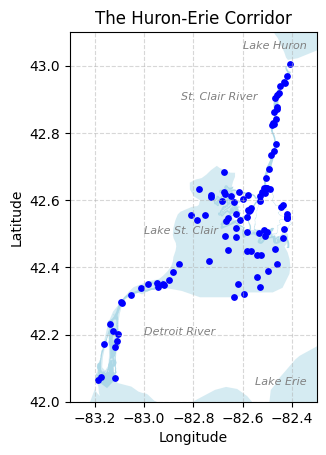

In [3]:
# create a canva that has the rivers and lakes as background
fig, ax = plot_rivers_lakes(annotating=True)
# take out the sampling sites' coordinates
site_info = data[("sample_info", "raw")].copy()
# plot the sampling sites on the map
ax.scatter(site_info["Longitude"], site_info["Latitude"], color='blue', s=15, label='Sampling Sites')
ax.grid(linestyle='--', alpha=0.5)

Plot the specific distribution of an example habitat feature, indicating the spatial patterns existing behind the data.

In [4]:
# plot a specific habitat feature's spatial distribution and boxplot
import seaborn as sns
from scipy.stats import f_oneway
from scipy.stats import gaussian_kde
import numpy as np
import matplotlib.pyplot as plt

def plot_feature_analysis(df, feature_name, lat_col='Latitude', lon_col='Longitude', waterbody_col='Waterbody'):
    """
    Plot a specific habitat feature's spatial distribution and statistical analysis.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing the data
    feature_name : str
        Name of the feature column to analyze
    lat_col : str
        Name of the latitude column (default: 'Latitude')
    lon_col : str
        Name of the longitude column (default: 'Longitude')
    waterbody_col : str
        Name of the waterbody column (default: 'Waterbody')
    """
    
    # Create a figure with three subplots: left for map, right side split into two
    fig = plt.figure(figsize=(10, 6), dpi=300)

    # Create subplot layout: left panel takes 1/2 width, right panel split into 2 rows
    ax1 = plt.subplot2grid((2, 2), (0, 0), rowspan=2)  # Map spans full left side (1/2 width)
    ax2 = plt.subplot2grid((2, 2), (0, 1))  # Upper right: ridge plot comparison
    ax3 = plt.subplot2grid((2, 2), (1, 1))  # Lower right: ANOVA test results

    # Left panel: Spatial distribution map
    plot_rivers_lakes(ax=ax1, annotating=True)
    # Normalize the feature values to create relative sizes
    feature_values = df[feature_name]
    normalized_sizes = ((feature_values - feature_values.min()) / 
                       (feature_values.max() - feature_values.min()) * 100 + 5)
    
    sc = ax1.scatter(df[lon_col], df[lat_col], c=df[feature_name], 
                     s=normalized_sizes, cmap='viridis', alpha=0.7)
    ax1.set_title(f"Spatial Distribution of {feature_name}", fontsize=14, fontweight='bold')
    ax1.grid(linestyle='--', alpha=0.5)

    # Add colorbar for the scatter plot
    cbar = plt.colorbar(sc, ax=ax1, shrink=0.8)
    cbar.set_label(feature_name, fontsize=12)

    # Upper right: Ridge plot-style comparison across waterbodies
    waterbodies = df[waterbody_col].unique()

    # Create blue gradient colors
    n_bodies = len(waterbodies)
    colors = plt.cm.Blues(np.linspace(0.3, 0.9, n_bodies))

    # Set up the ridge plot parameters
    ridge_height = 0.8  # Height of each ridge
    ridge_spacing = 1.0  # Vertical spacing between ridges
    baseline_offset = 0.1  # Small offset from baseline

    # Clear the axis and set up for ridge plot
    ax2.clear()

    # Create ridge plot with proper stacking
    for i, wb in enumerate(waterbodies):
        data_wb = df[df[waterbody_col] == wb][feature_name].dropna()
        if len(data_wb) > 1:
            # Create smooth density curve using Gaussian KDE
            kde = gaussian_kde(data_wb)
            
            # Create x values for smooth curve
            x_min, x_max = data_wb.min(), data_wb.max()
            x_range = x_max - x_min
            x_smooth = np.linspace(x_min - 0.1*x_range, x_max + 0.1*x_range, 200)
            
            # Calculate density values
            density = kde(x_smooth)
            
            # Normalize density to ridge height
            normalized_density = (density / density.max()) * ridge_height
            
            # Calculate y position for this ridge (bottom to top)
            y_baseline = i * ridge_spacing
            y_values = y_baseline + normalized_density + baseline_offset
            
            # Create the filled area
            ax2.fill_between(x_smooth, y_baseline + baseline_offset, y_values, 
                            color=colors[i], alpha=0.8, edgecolor='white', linewidth=0.5)
            
            # Add a subtle baseline for each ridge
            ax2.axhline(y=y_baseline + baseline_offset, color='lightgray', 
                       linestyle='-', linewidth=0.5, alpha=0.7)

    # Set up the y-axis
    ax2.set_ylim(-0.2, len(waterbodies) * ridge_spacing + 0.5)
    ax2.set_yticks([i * ridge_spacing + baseline_offset + ridge_height/2 for i in range(len(waterbodies))])
    ax2.set_yticklabels(waterbodies, fontsize=11)

    # Style the plot
    ax2.set_title(f"Overlapping densities ('ridge plot')", fontsize=10, fontweight='bold')
    ax2.set_xlabel(feature_name, fontsize=11)
    ax2.grid(True, alpha=0.3, axis='x')
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)

    # Lower right: ANOVA test results with bar plot
    waterbody_groups = [df[df[waterbody_col] == wb][feature_name].dropna() 
                       for wb in waterbodies]
    f_stat, p_value = f_oneway(*waterbody_groups)

    # Calculate means and standard errors
    means = [group.mean() for group in waterbody_groups]
    std_errors = [group.std() / np.sqrt(len(group)) for group in waterbody_groups]

    # Create bar plot with error bars using the same blue gradient
    bars = ax3.bar(waterbodies, means, yerr=std_errors, 
                   alpha=0.8, color=colors, capsize=5, 
                   error_kw={'linewidth': 2, 'markeredgewidth': 2})

    # Add value labels on bars
    for i, (bar, mean) in enumerate(zip(bars, means)):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + std_errors[i] + height*0.02,
                 f'{mean:.2f}', ha='center', va='bottom', fontweight='bold')

    ax3.set_title(f"ANOVA Test: Mean {feature_name} by Waterbody\nF={f_stat:.3f}, p={p_value:.4f}", 
                  fontsize=10, fontweight='bold')
    ax3.set_ylabel(f"Mean {feature_name} ± SE", fontsize=11)
    ax3.set_xlabel("Waterbody", fontsize=11)
    ax3.grid(True, alpha=0.3, axis='y')
    ax3.spines['top'].set_visible(False)
    ax3.spines['right'].set_visible(False)
    ax3.spines['left'].set_visible(False)

    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.3, hspace=0.4)

    plt.show()
    
    return fig, f_stat, p_value

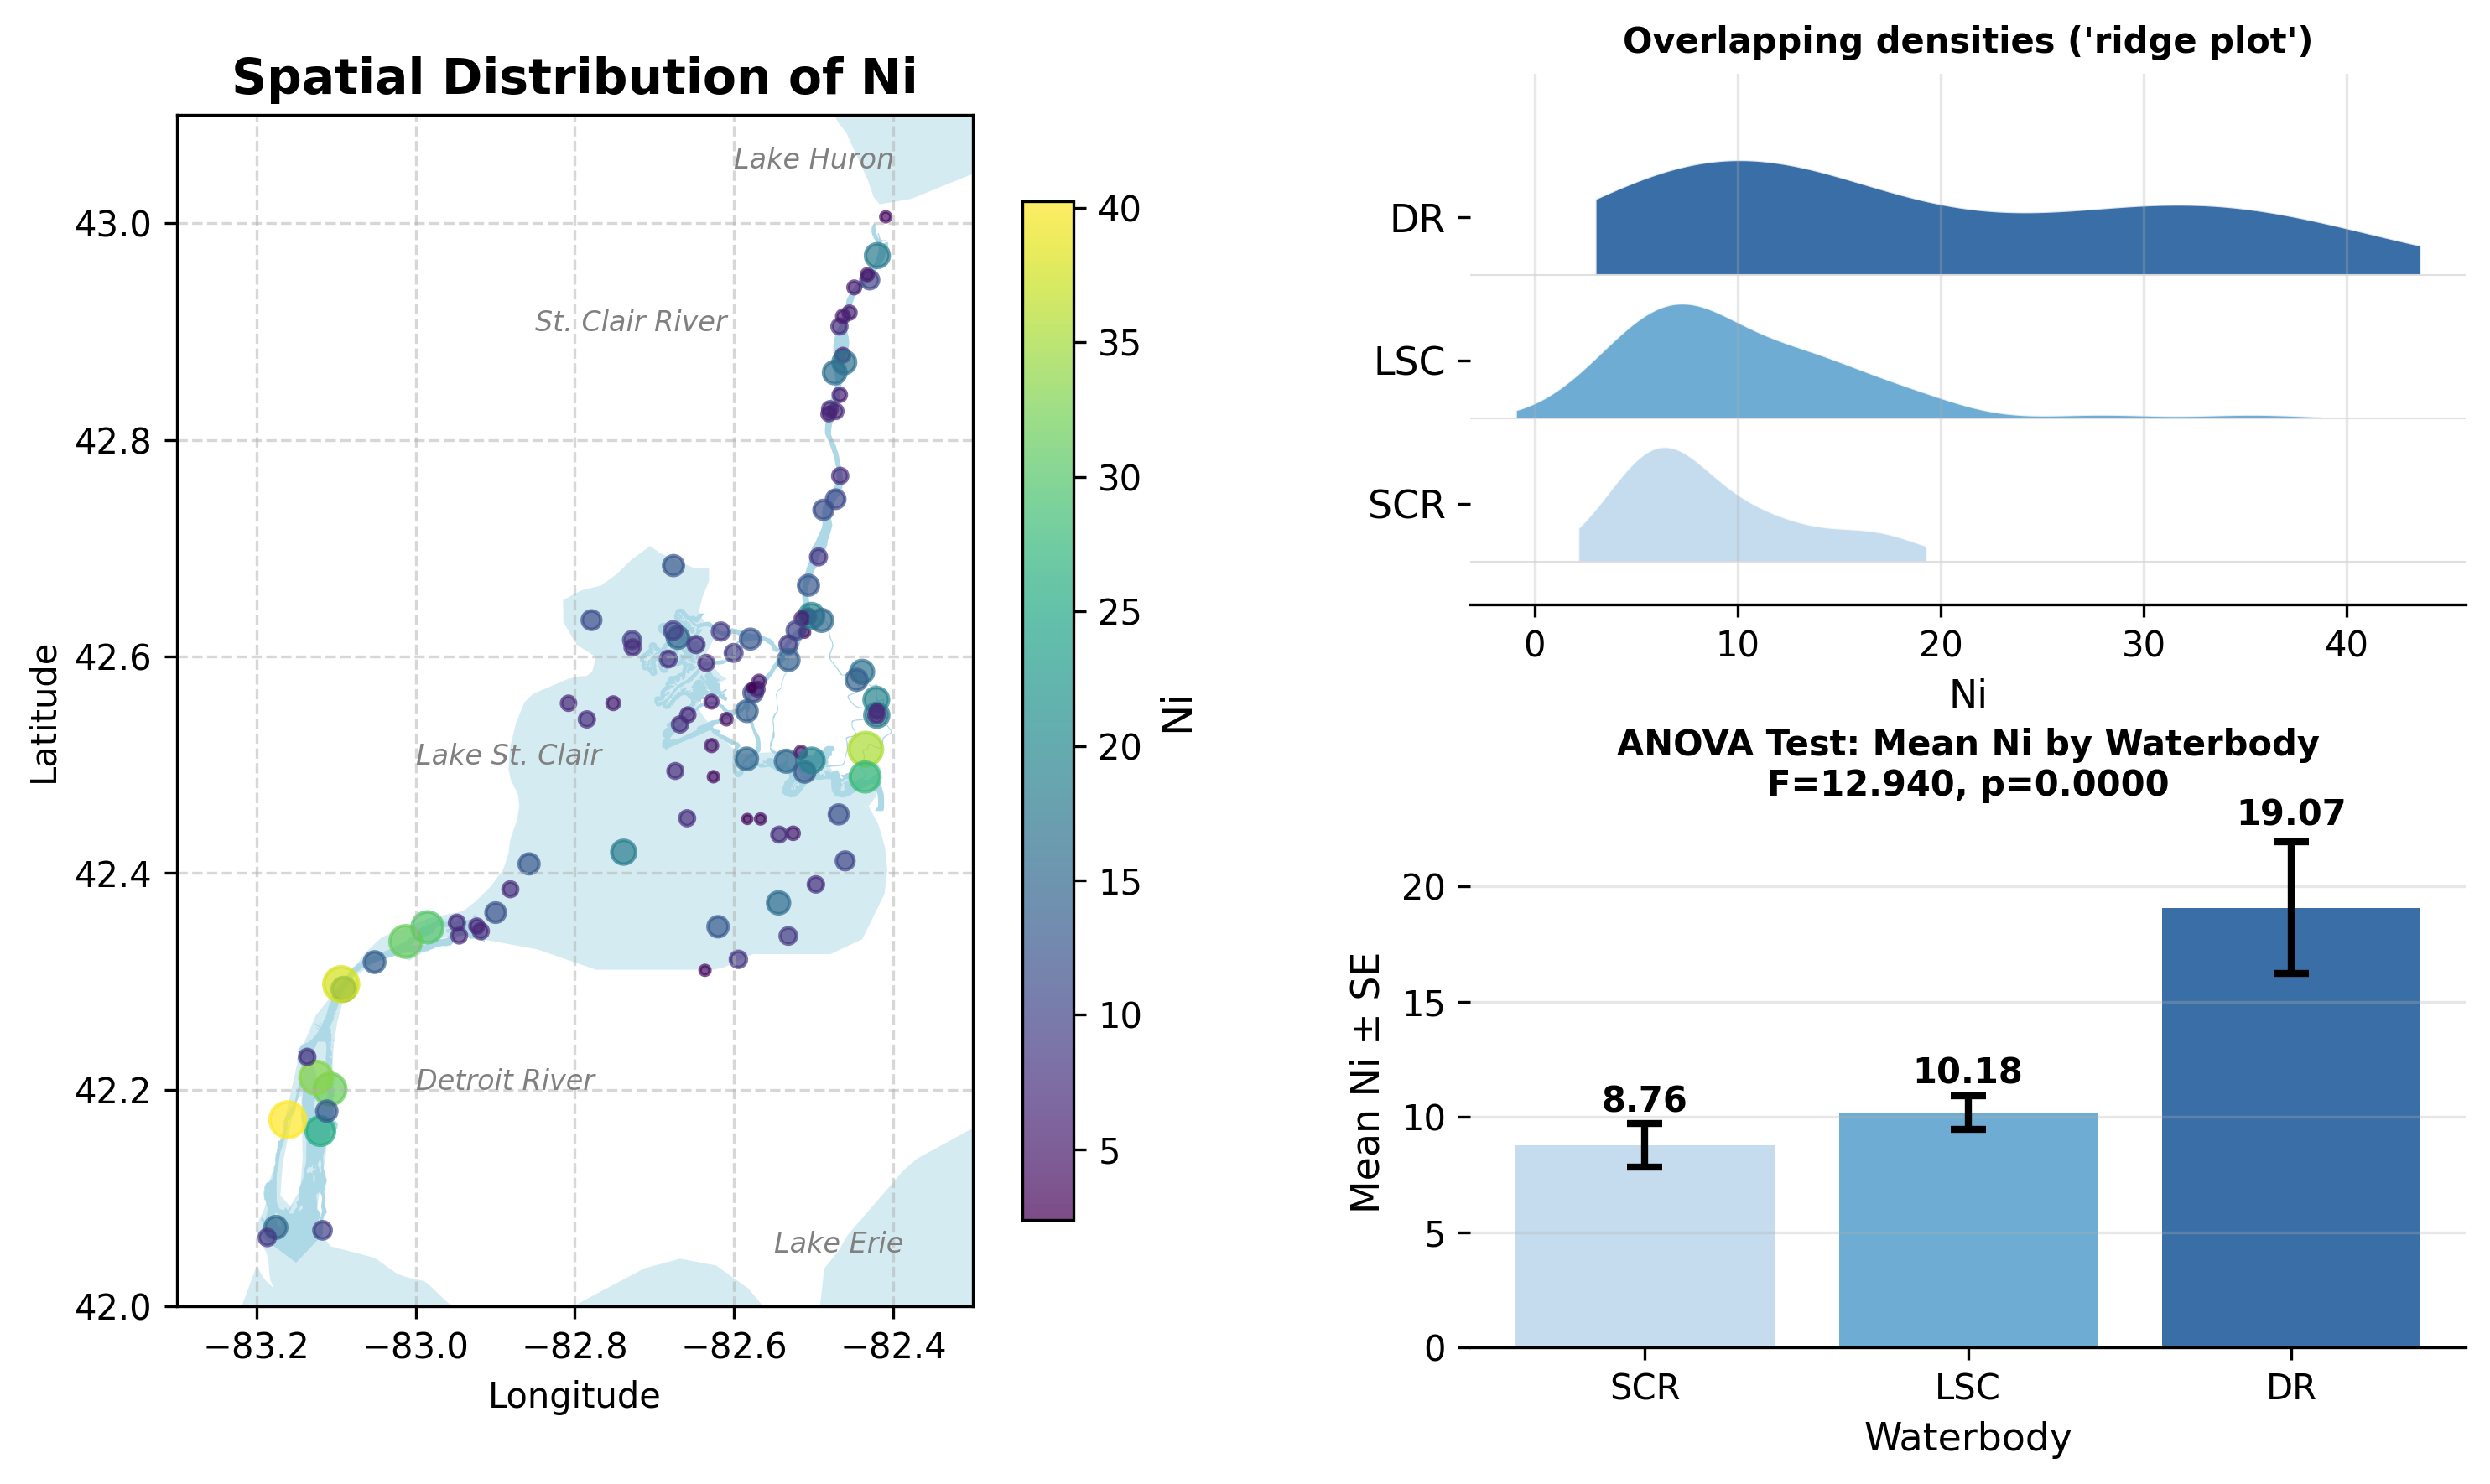

In [5]:
# Example usage with the existing data
feature_name = "Ni" # this 'Ni' was decided by checking the correlation matrix, its highly correlated with other metals
fig, f_stat, p_value = plot_feature_analysis(raw_data, feature_name)

## 2. Check the distribution of each feature and detect outliers

To the three types of features, contamination, habitat, and taxa, we check their histograms respectively.
To each raw individual feature, compute its shapiro-wilk test p-value and show them together with the histogram.

In [6]:
# define a function to plot histograms and compute shapiro-wilk test p-values for all columns in a dataframe
from scipy.stats import shapiro
def plot_histograms_with_shapiro(df):
    num_cols = df.shape[1]
    n_rows = (num_cols + 2) // 5 # columns
    fig, axes = plt.subplots(n_rows, 5, figsize=(18, 4 * n_rows))
    axes = axes.flatten()
    for i, col in enumerate(df.columns):
        data_col = df[col].dropna()
        axes[i].hist(data_col, bins=20, color='lightblue', edgecolor='black', alpha=0.7)
        stat, p_value = shapiro(data_col)
        axes[i].set_title(f'Histogram of {col}\nshapiro $p$-value: {p_value:.4f}')
        # compute the outliers in the column using 1.5*IQR rule
        Q1 = data_col.quantile(0.25)
        Q3 = data_col.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = data_col[(data_col < lower_bound) | (data_col > upper_bound)]
        axes[i].axvline(lower_bound, color='red', linestyle='dashed', linewidth=1)
        axes[i].axvline(upper_bound, color='red', linestyle='dashed', linewidth=1)
        axes[i].text(0.95, 0.95, f'Outliers: {len(outliers)}', 
                     transform=axes[i].transAxes, 
                     verticalalignment='top', horizontalalignment='right',
                     color='red', fontsize=10)
    
    plt.tight_layout()

First check the habitat features and their distributions.

/var/folders/s5/r1s56_ps46lbbv1370hjn_vr0000gn/T/ipykernel_2231/2049309530.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  plot_histograms_with_shapiro(data[("chemical", "raw")])


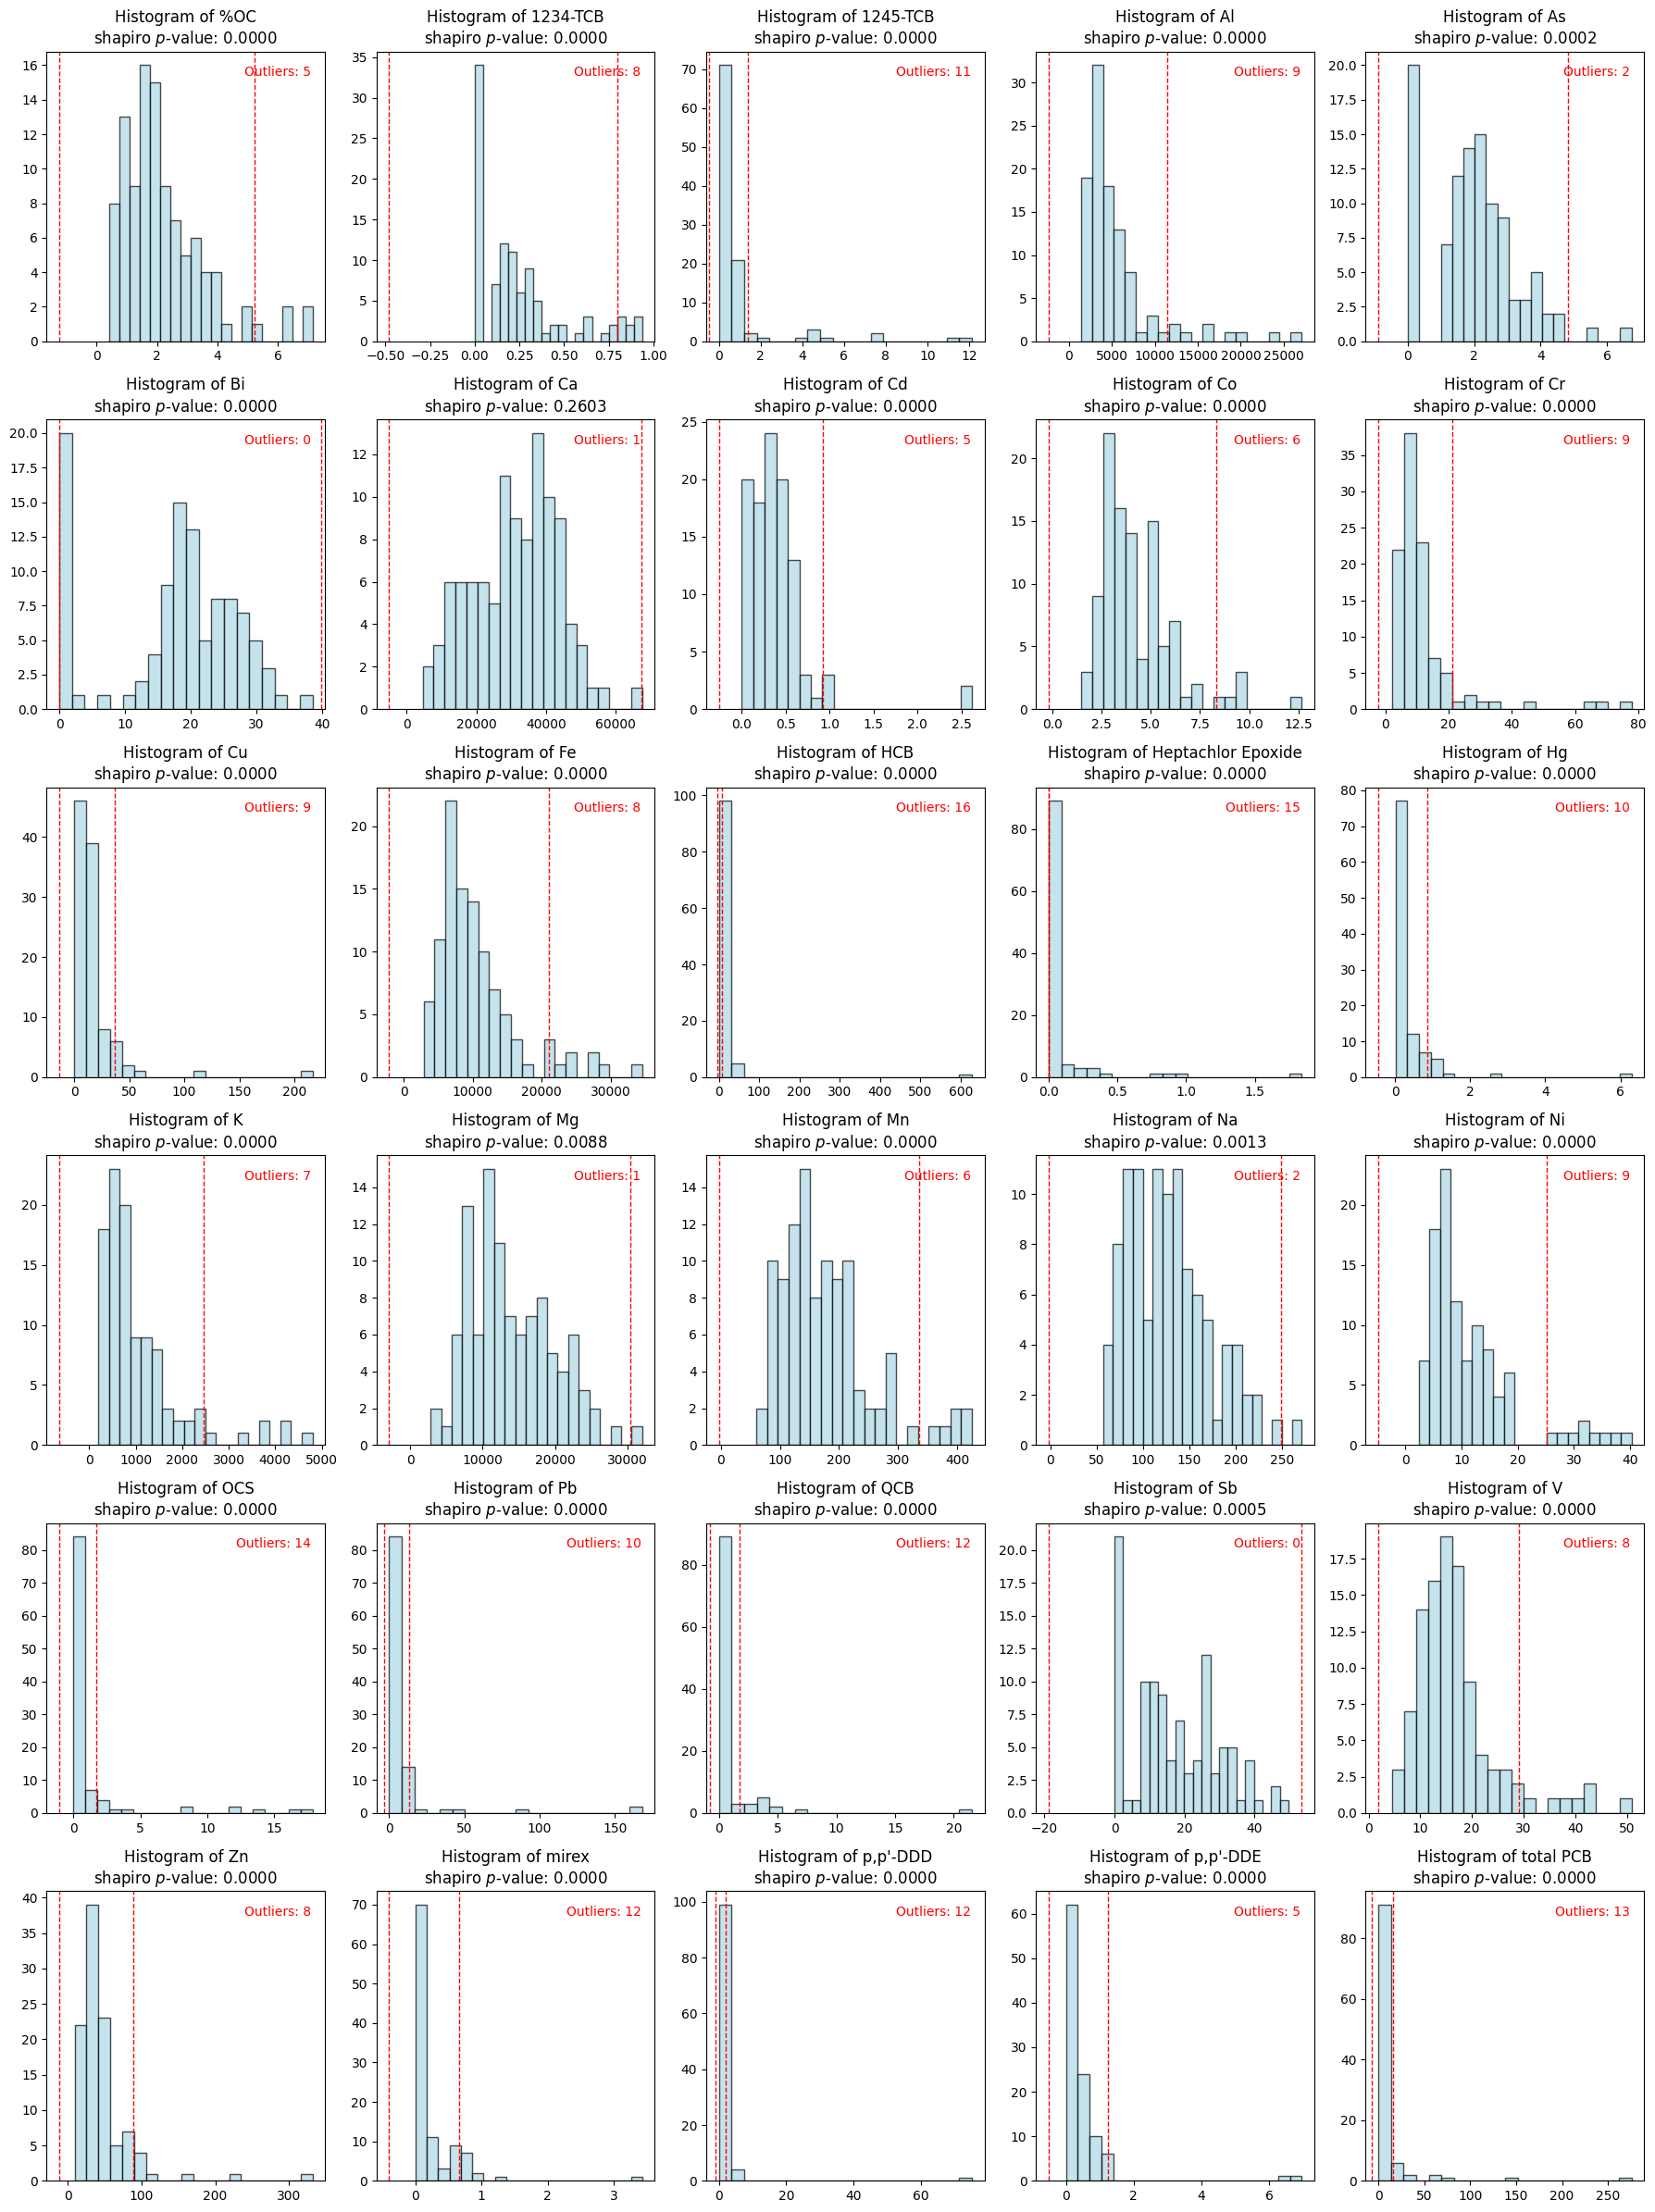

In [7]:
# assign a block type to plot their distributions and outliers
plot_histograms_with_shapiro(data[("chemical", "raw")])

Check the paired density and scatter plots on these raw habitat features.

In [8]:
import seaborn as sns
# sns.set_theme(style="white")

# g = sns.PairGrid(data[("chemical", "raw")], diag_sharey=False)
# g.map_upper(sns.scatterplot, s=15)
# g.map_lower(sns.kdeplot)
# g.map_diag(sns.kdeplot, lw=2)

Simply compute the covariance matrix and correlation matrix of these habitat features to see their relationships.

In [9]:
# define the function to compute clustered correlation matrix with highlighted cells
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import leaves_list
def compute_clustered_correlation(df, title="Clustered Correlation Matrix"):
    """
    Compute and display correlation matrix with hierarchical clustering ordering.
    
    Parameters:
    df: pandas DataFrame - the dataframe to compute correlations for
    title: str - title for the correlation matrix display
    
    Returns:
    clustered_styled_corr: pandas Styler object - styled correlation matrix
    """
    # Compute correlation matrix
    corr_matrix = df.corr()
    
    # Convert correlation matrix to distance matrix
    distance_matrix = 1 - corr_matrix.abs()
    
    # Perform hierarchical clustering
    linkage_matrix = linkage(squareform(distance_matrix), method='average')
    
    # Get the order of variables from clustering
    cluster_order = leaves_list(linkage_matrix)
    ordered_columns = corr_matrix.columns[cluster_order]
    
    # Reorder the correlation matrix
    clustered_corr = corr_matrix.loc[ordered_columns, ordered_columns]
    
    # Style the reordered correlation matrix
    clustered_styled_corr = clustered_corr.style.background_gradient(cmap='RdBu_r', vmin=-1, vmax=1)\
        .format(precision=2)\
        .set_caption(title)
    
    return clustered_styled_corr

In [10]:
# Apply the function to the raw chemical features
compute_clustered_correlation(
    data[("chemical", "raw")], 
    "Clustered Correlation Matrix of Chemical Features"
)

/var/folders/s5/r1s56_ps46lbbv1370hjn_vr0000gn/T/ipykernel_2231/2902376126.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  data[("chemical", "raw")],


var,1234-TCB,HCB,QCB,1245-TCB,OCS,Heptachlor Epoxide,"p,p'-DDE",mirex,Hg,"p,p'-DDD",Cd,Pb,total PCB,Ni,Cr,Cu,Zn,%OC,Mn,Fe,Co,V,Al,K,Na,Ca,Mg,As,Bi,Sb
var,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1234-TCB,1.00,0.09,0.03,-0.13,-0.11,-0.01,0.03,0.07,0.00,-0.01,0.18,0.05,0.04,0.14,0.14,0.09,0.17,0.17,0.14,0.18,0.09,0.14,0.05,0.08,0.00,0.15,0.13,-0.02,0.02,-0.09
HCB,0.09,1.00,0.92,0.33,0.43,0.06,-0.05,-0.03,0.05,-0.03,-0.00,-0.03,-0.02,-0.01,-0.05,-0.08,-0.03,-0.06,-0.05,0.39,0.03,-0.07,-0.02,-0.04,0.11,0.08,-0.01,-0.14,-0.10,-0.10
QCB,0.03,0.92,1.00,0.62,0.68,0.06,-0.09,-0.07,0.16,-0.04,0.07,-0.04,0.00,0.04,-0.04,-0.07,-0.01,0.02,0.02,0.36,0.10,-0.03,0.01,0.01,0.25,0.22,0.17,-0.09,0.00,-0.09
1245-TCB,-0.13,0.33,0.62,1.00,0.81,-0.03,-0.13,-0.09,0.27,-0.04,0.18,-0.01,0.06,0.12,0.02,0.01,0.06,0.18,0.11,0.13,0.16,0.05,0.07,0.11,0.37,0.34,0.38,0.04,0.11,-0.08
OCS,-0.11,0.43,0.68,0.81,1.00,-0.06,-0.15,-0.13,0.17,-0.05,0.14,-0.04,0.06,0.09,-0.01,-0.02,0.02,0.08,0.09,0.16,0.15,0.02,0.03,0.05,0.40,0.34,0.33,0.01,0.09,-0.08
Heptachlor Epoxide,-0.01,0.06,0.06,-0.03,-0.06,1.00,0.12,0.18,0.07,0.06,0.11,-0.00,0.01,-0.13,-0.09,-0.09,-0.06,-0.12,-0.16,-0.10,-0.14,-0.13,-0.14,-0.14,-0.17,-0.07,-0.14,-0.05,0.13,0.24
"p,p'-DDE",0.03,-0.05,-0.09,-0.13,-0.15,0.12,1.00,0.65,0.51,0.70,0.35,0.44,0.30,0.35,0.40,0.33,0.28,0.15,0.20,0.20,0.22,0.24,0.21,0.21,0.06,-0.05,-0.03,0.14,-0.29,-0.20
mirex,0.07,-0.03,-0.07,-0.09,-0.13,0.18,0.65,1.00,0.62,0.74,0.43,0.44,0.31,0.20,0.34,0.26,0.21,0.10,-0.05,0.03,0.03,0.04,0.04,0.02,-0.12,-0.11,-0.08,-0.03,-0.15,-0.09
Hg,0.00,0.05,0.16,0.27,0.17,0.07,0.51,0.62,1.00,0.83,0.67,0.58,0.41,0.32,0.44,0.36,0.32,0.21,0.06,0.06,0.13,0.07,0.04,0.07,0.16,0.12,0.13,0.09,-0.02,-0.07


Take log-transformation on these pollution features to make them more Gaussian-like and reduce the effects of extreme outliers.

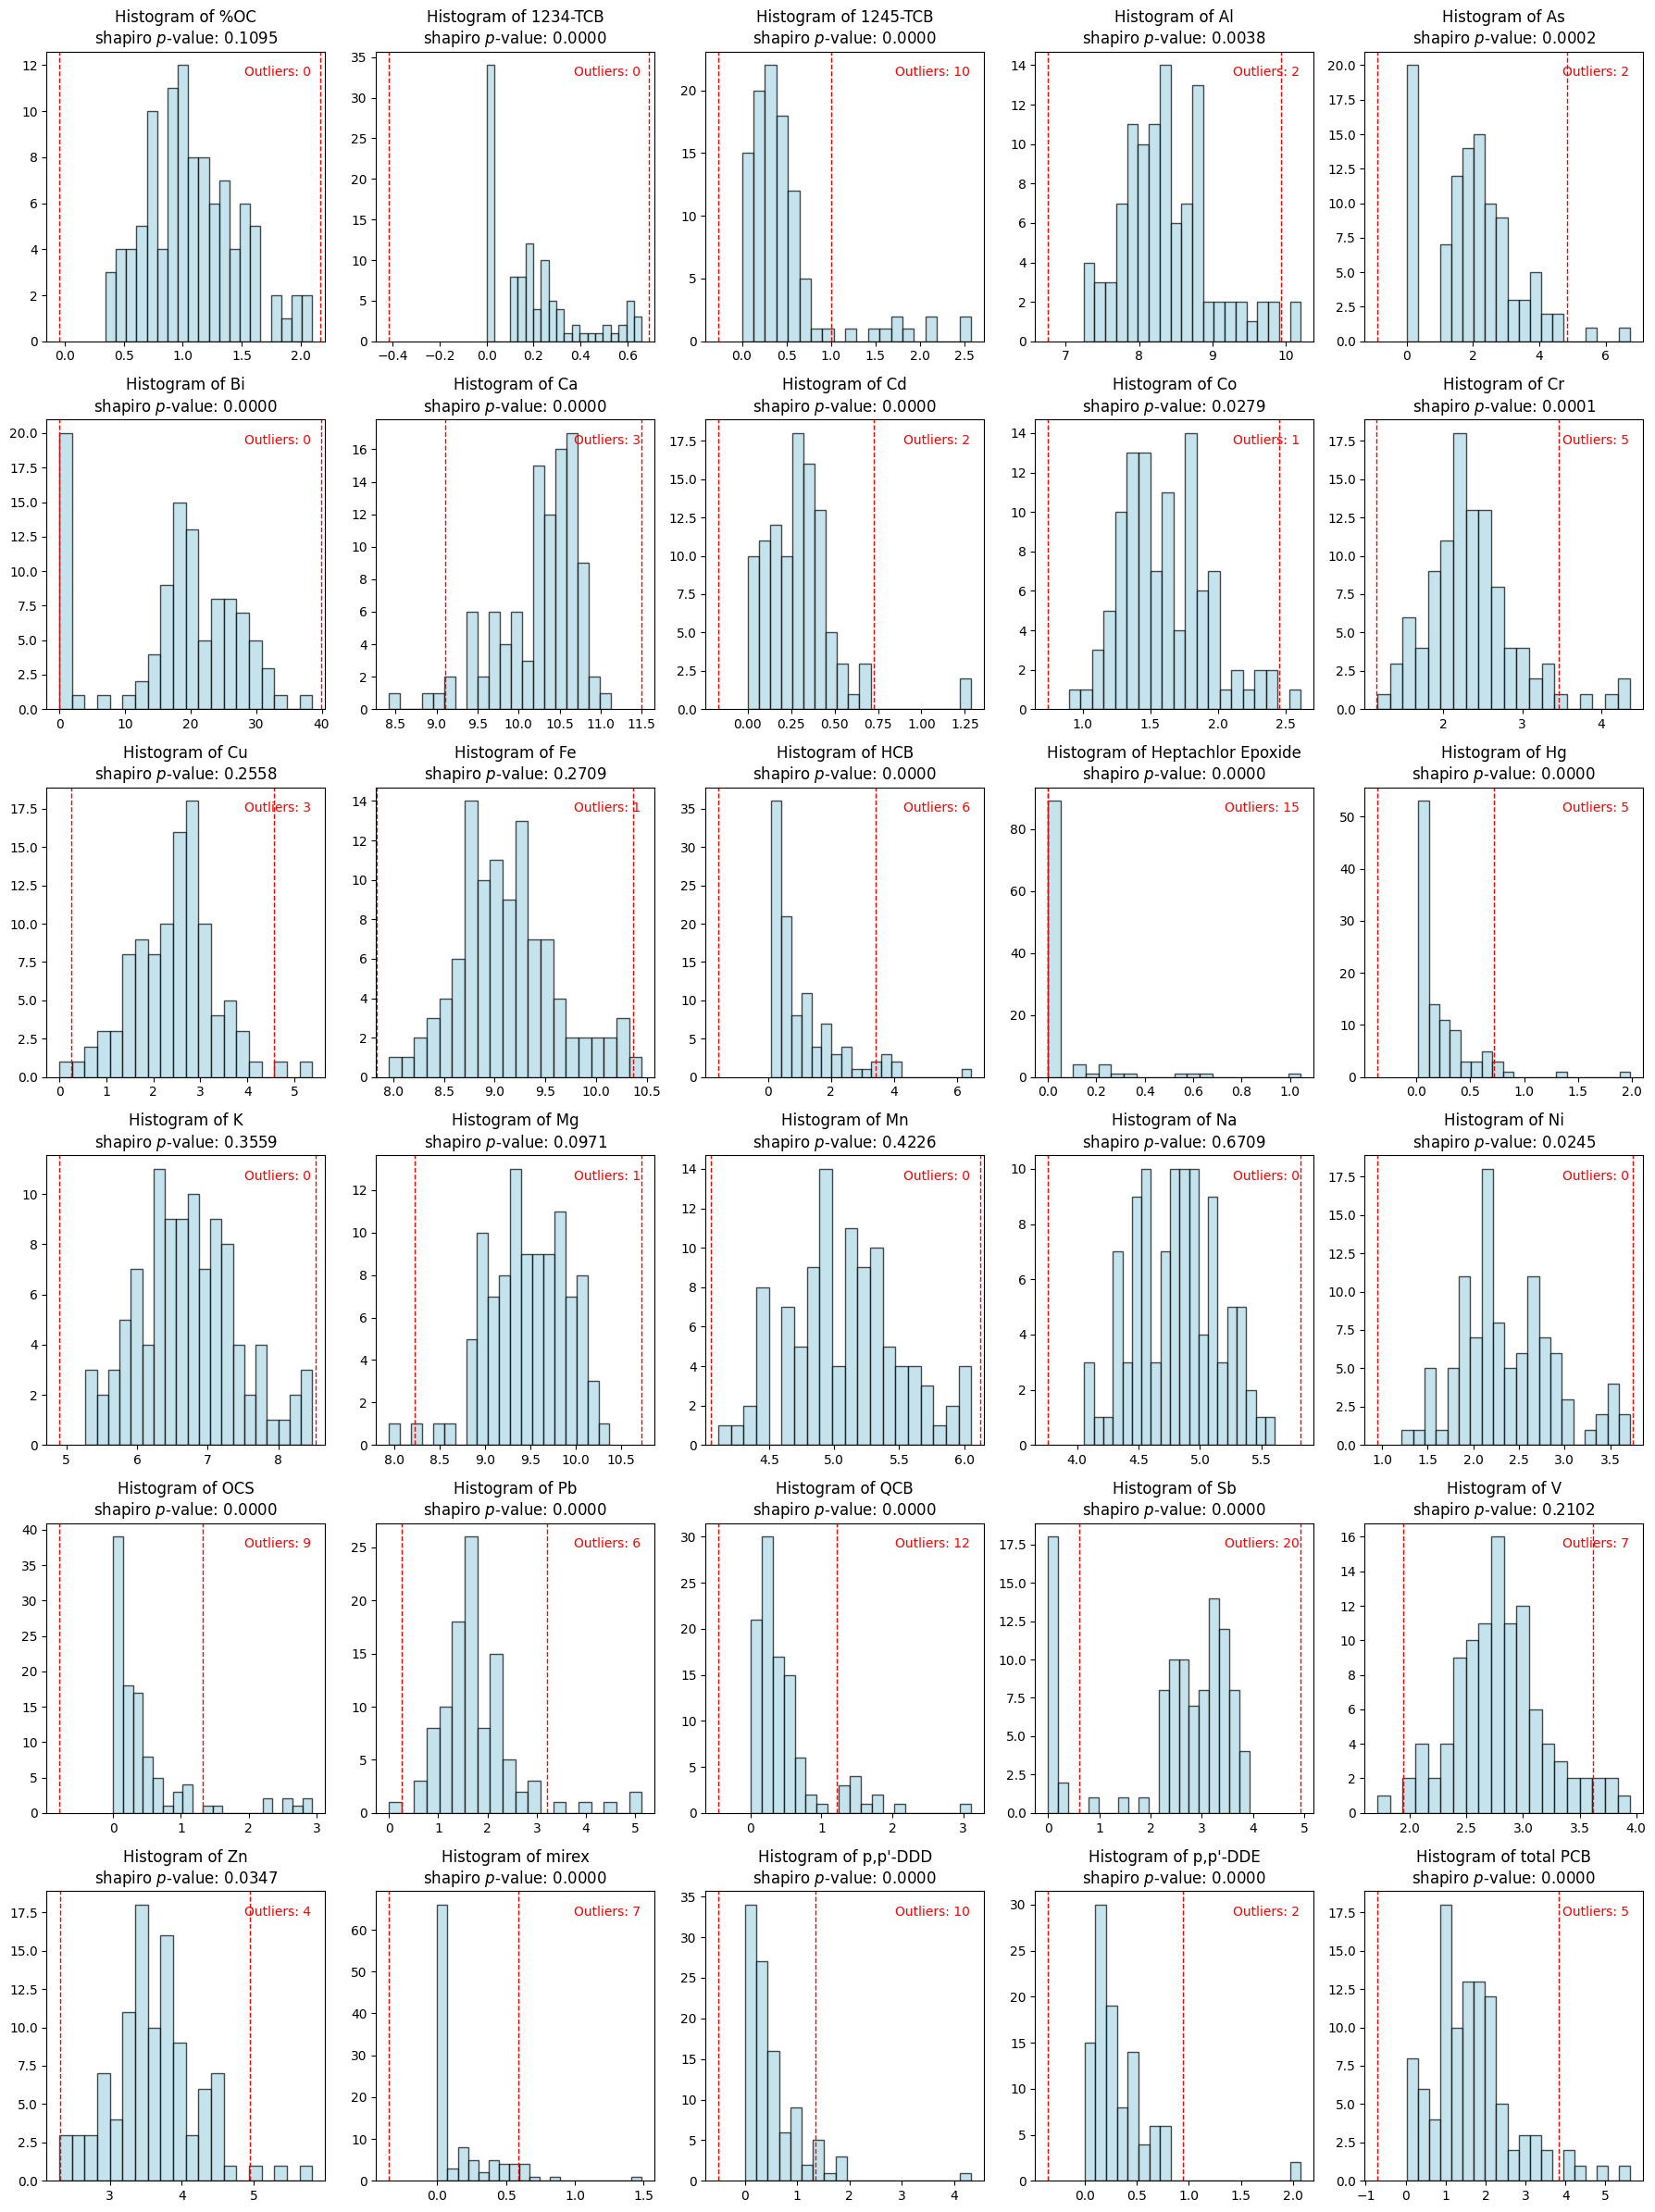

In [11]:
# take log1p transformation on the pollution features
import numpy as np
pollution_data = get_block(data, block="chemical", subblock="raw")
# avoid transforming the 'As' and 'Bi' variables, exponentialize them first
pollution_data[["As", "Bi"]] = np.expm1(pollution_data[["As", "Bi"]])
log_transformed_pollution = np.log1p(pollution_data)
# plot the log-transformed pollution features' distributions
plot_histograms_with_shapiro(log_transformed_pollution)

Compute the hierarchical clustered correlation matrix for the log-transformed chemical features

After the log-transformation, check their paired distribution and scatter plots again.

In [12]:
# Apply the function to the raw chemical features
compute_clustered_correlation(
    log_transformed_pollution,
    "Clustered Correlation Matrix of log-transformed Chemical Features"
)

var,Heptachlor Epoxide,1234-TCB,mirex,"p,p'-DDD","p,p'-DDE",As,Bi,Sb,Ca,Mg,Pb,Cu,Zn,Cr,Ni,Na,%OC,Mn,Fe,V,Co,Al,K,OCS,HCB,1245-TCB,QCB,total PCB,Cd,Hg
var,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Heptachlor Epoxide,1.00,0.01,0.12,0.04,0.18,-0.04,0.13,0.14,-0.03,-0.12,-0.05,-0.22,-0.05,-0.17,-0.16,-0.17,-0.11,-0.17,-0.11,-0.14,-0.16,-0.18,-0.13,-0.08,0.08,-0.00,0.08,0.10,0.15,0.06
1234-TCB,0.01,1.00,0.13,0.12,0.07,0.00,-0.00,-0.10,0.20,0.17,0.18,0.14,0.22,0.20,0.19,0.03,0.21,0.19,0.25,0.22,0.13,0.13,0.15,-0.10,0.10,-0.03,0.00,0.15,0.19,0.06
mirex,0.12,0.13,1.00,0.41,0.50,-0.06,-0.12,-0.12,-0.05,-0.04,0.25,0.13,0.20,0.18,0.11,-0.13,0.09,-0.06,0.04,0.02,0.02,0.03,0.02,-0.18,-0.08,-0.06,-0.09,0.25,0.27,0.32
"p,p'-DDD",0.04,0.12,0.41,1.00,0.70,0.29,-0.33,-0.36,0.02,0.04,0.49,0.42,0.37,0.43,0.38,0.15,0.27,0.24,0.29,0.25,0.26,0.21,0.16,-0.07,-0.05,-0.01,-0.03,0.44,0.30,0.43
"p,p'-DDE",0.18,0.07,0.50,0.70,1.00,0.16,-0.31,-0.28,-0.11,-0.10,0.34,0.24,0.23,0.31,0.23,-0.02,0.11,0.12,0.19,0.18,0.16,0.13,0.07,-0.26,-0.20,-0.21,-0.19,0.26,0.16,0.20
As,-0.04,0.00,-0.06,0.29,0.16,1.00,-0.44,-0.51,0.09,0.14,0.41,0.55,0.40,0.42,0.48,0.24,0.34,0.51,0.51,0.56,0.49,0.42,0.32,0.01,-0.09,0.03,-0.04,0.20,0.01,0.07
Bi,0.13,-0.00,-0.12,-0.33,-0.31,-0.44,1.00,0.91,0.21,0.18,-0.42,-0.47,-0.33,-0.45,-0.37,-0.09,-0.22,-0.19,-0.43,-0.30,-0.27,-0.27,-0.11,0.12,0.19,0.14,0.18,-0.18,0.17,0.07
Sb,0.14,-0.10,-0.12,-0.36,-0.28,-0.51,0.91,1.00,-0.03,-0.06,-0.53,-0.59,-0.54,-0.62,-0.60,-0.35,-0.45,-0.48,-0.70,-0.54,-0.54,-0.52,-0.38,0.04,0.05,-0.00,0.04,-0.32,0.04,-0.02
Ca,-0.03,0.20,-0.05,0.02,-0.11,0.09,0.21,-0.03,1.00,0.87,0.23,0.20,0.39,0.26,0.39,0.64,0.47,0.69,0.39,0.40,0.32,0.41,0.54,0.32,0.37,0.40,0.31,0.30,0.47,0.25


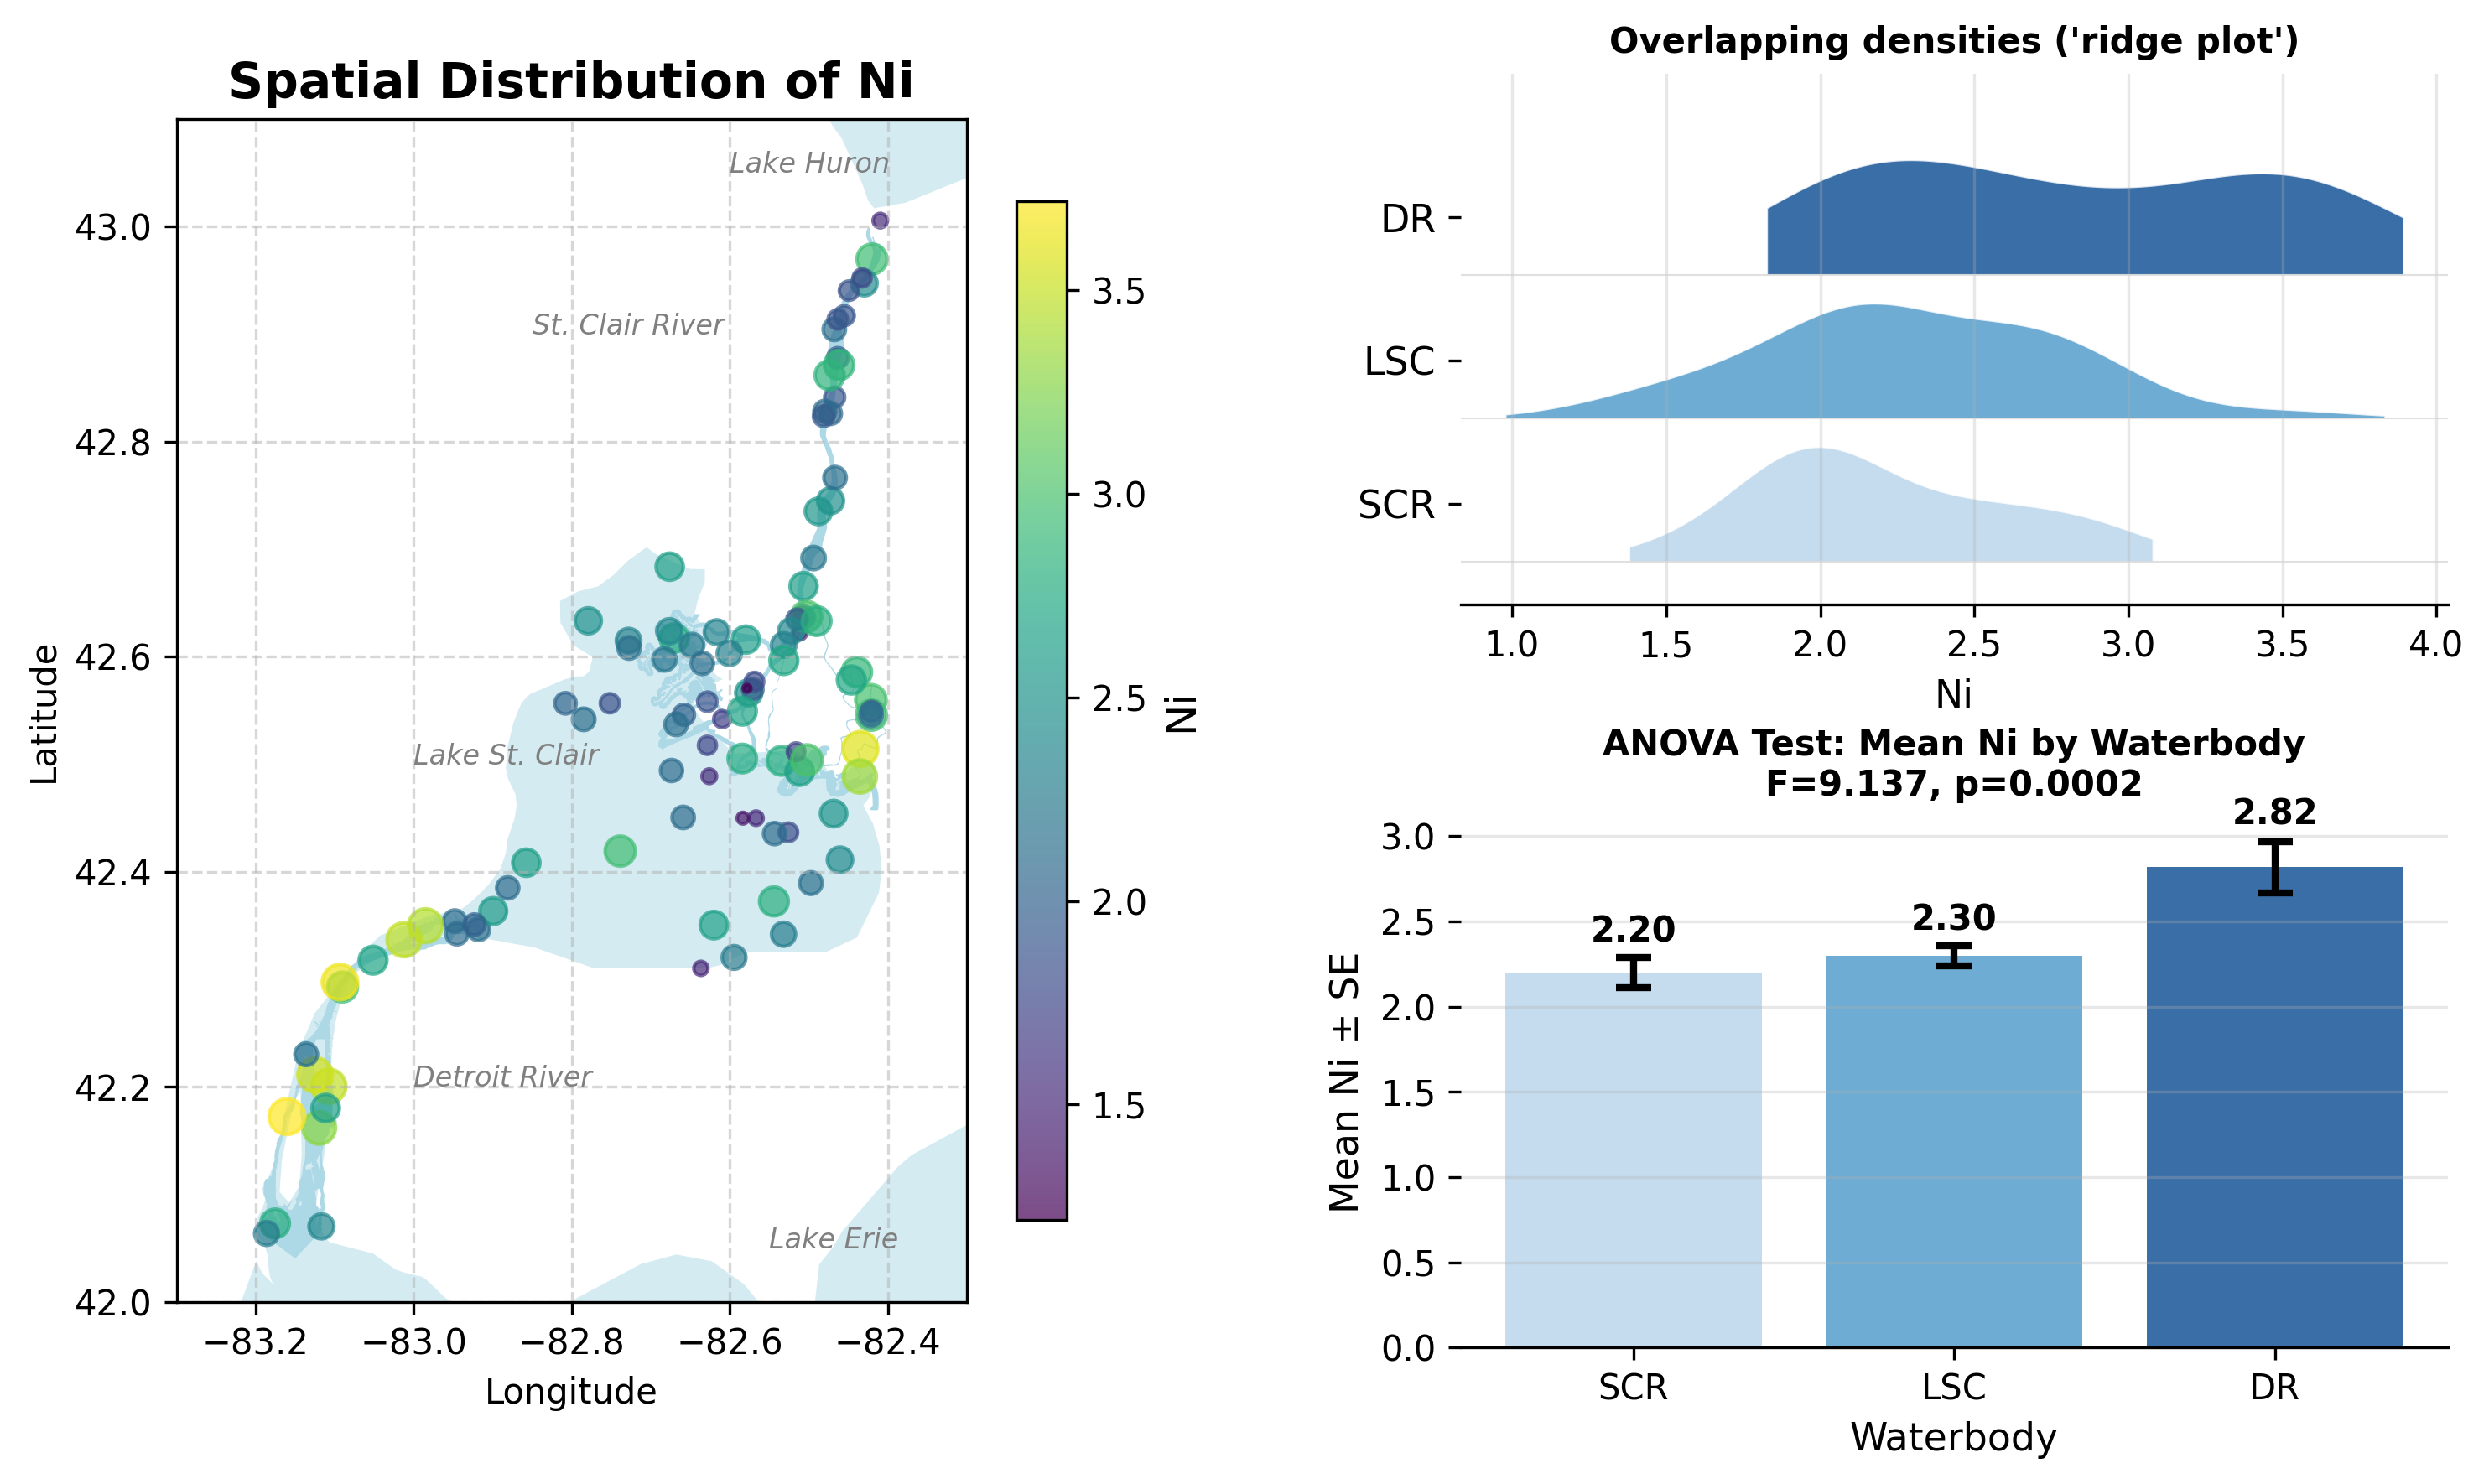

In [13]:
# check the spatial distribution of the transformed 'Ni' feature
feature_name = "Ni"
# add the location to the pollution data for plotting
log_transformed_pollution["Latitude"] = site_info["Latitude"]
log_transformed_pollution["Longitude"] = site_info["Longitude"]
log_transformed_pollution["Waterbody"] = site_info["Waterbody"]
fig, f_stat, p_value = plot_feature_analysis(log_transformed_pollution, feature_name)

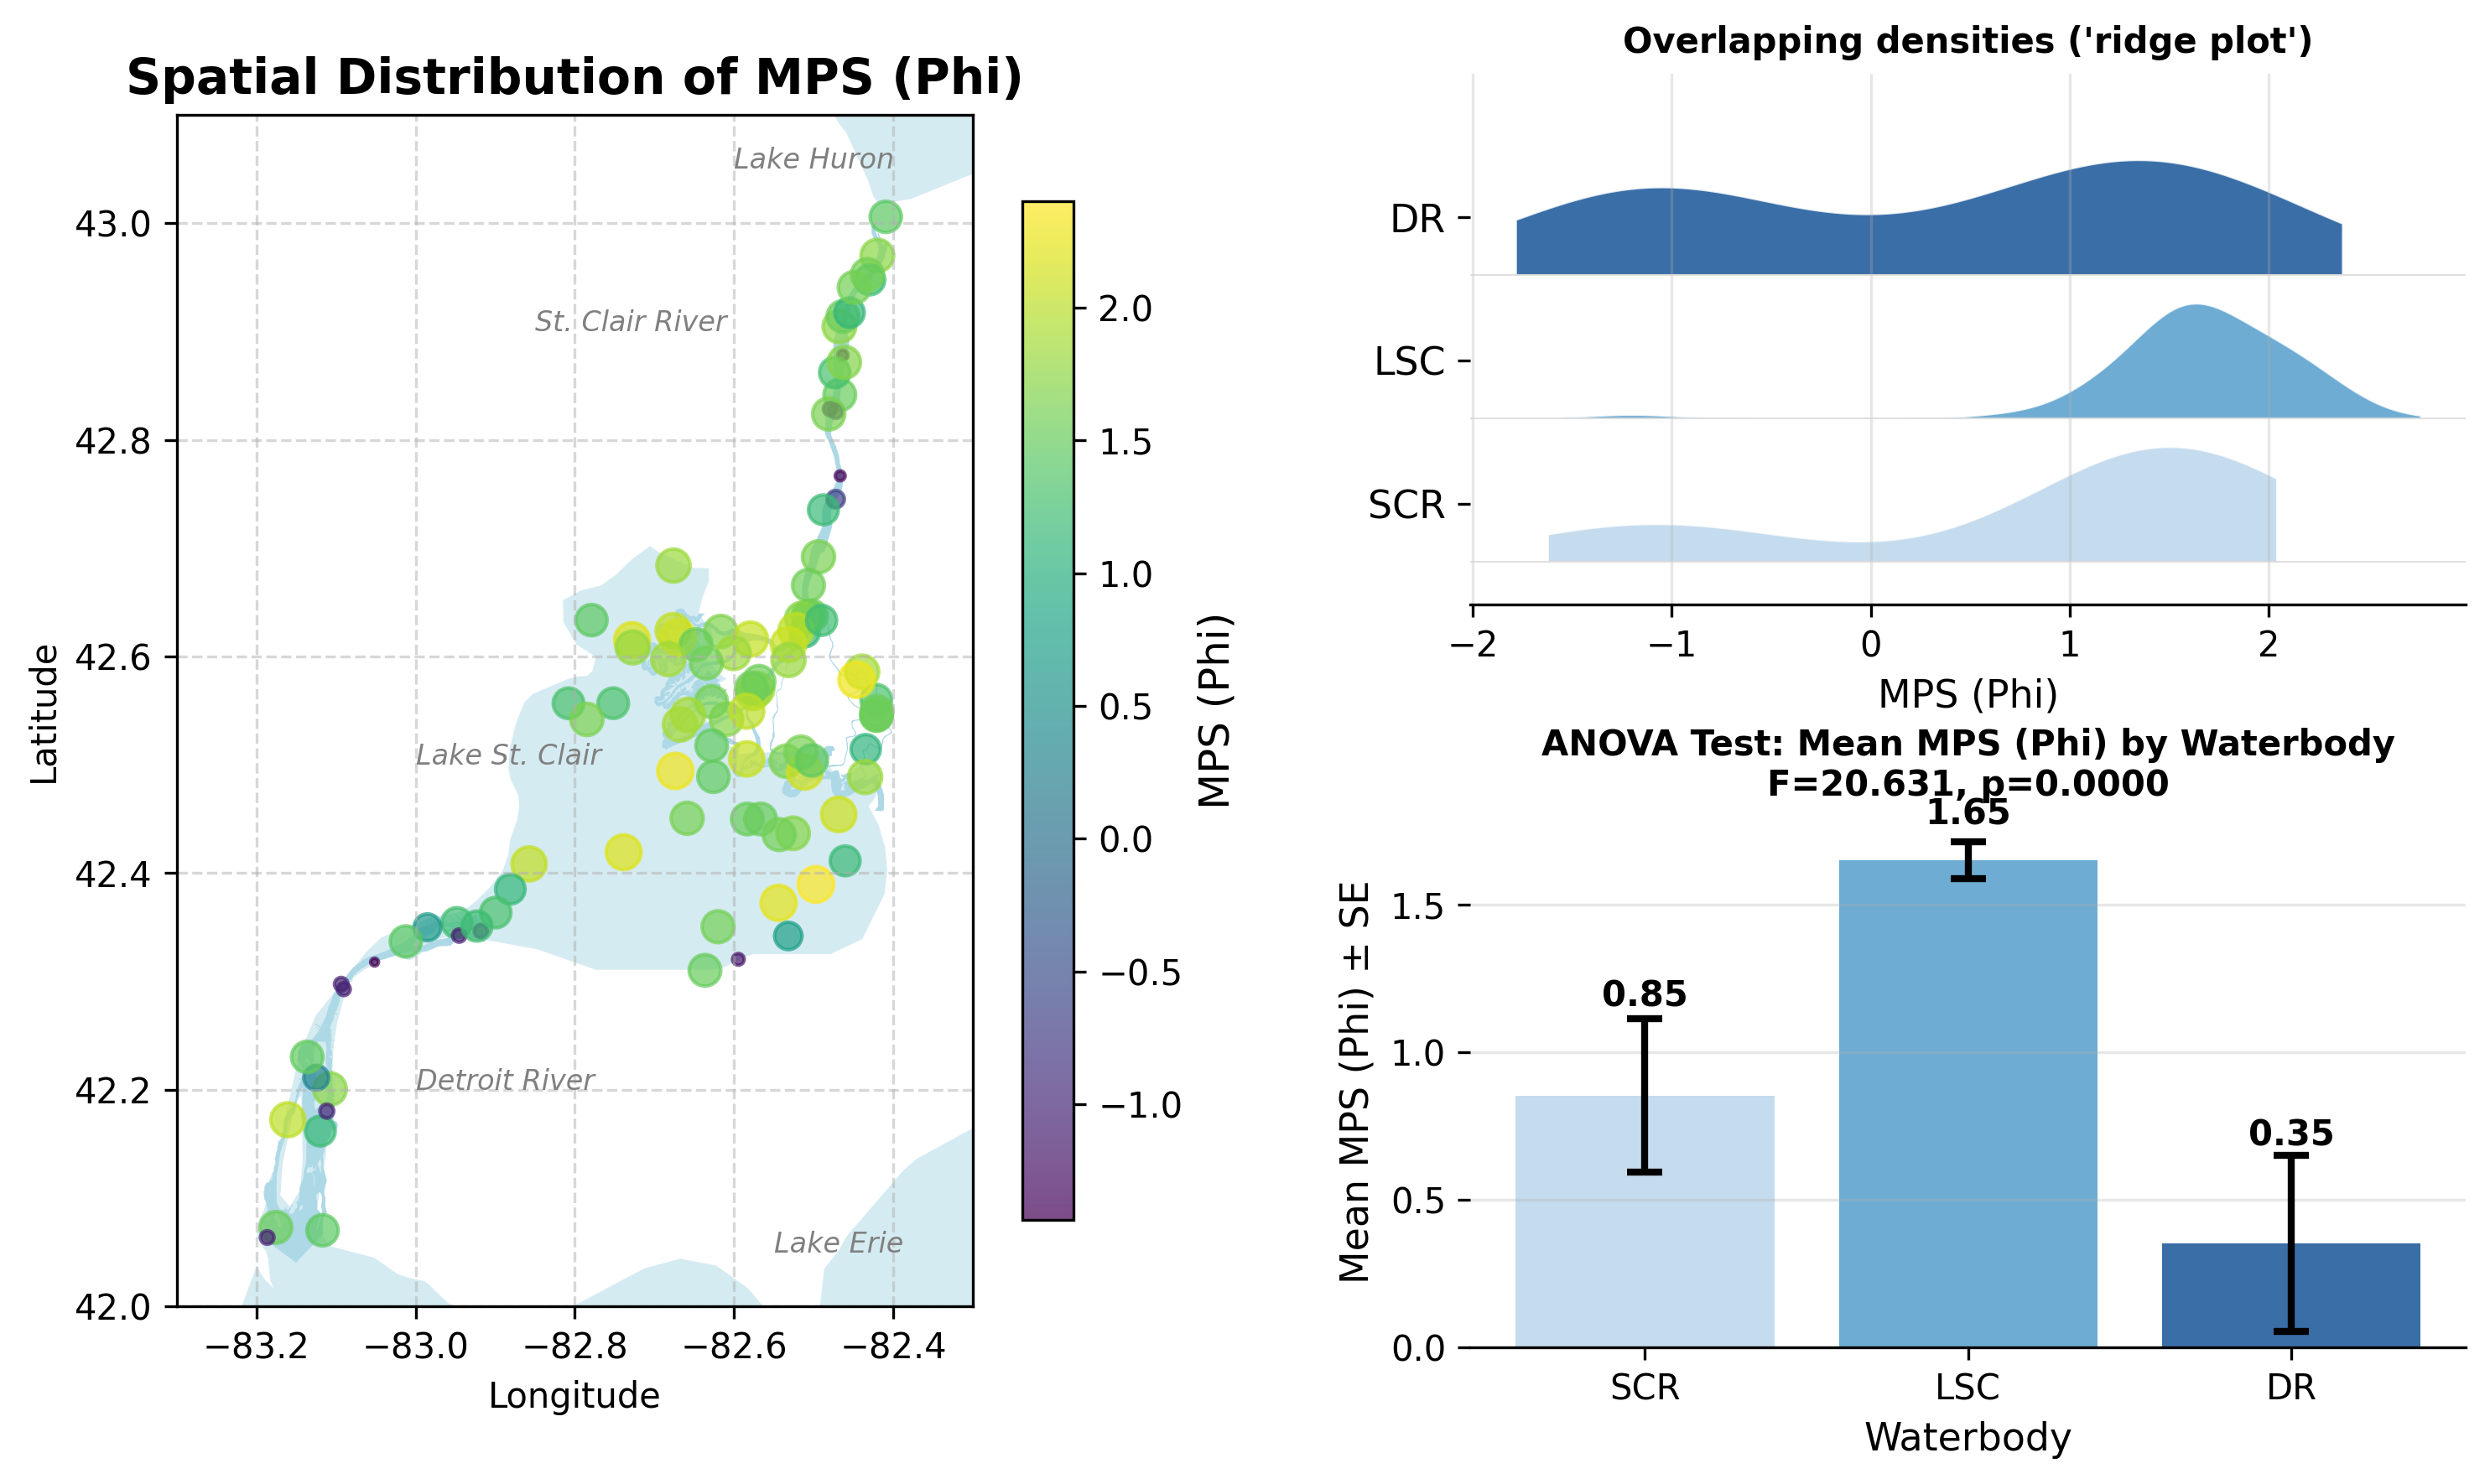

In [14]:
# test the spatial distribution of a habitat feature 'MPS (Phi)'
feature_name = "MPS (Phi)"
fig, f_stat, p_value = plot_feature_analysis(raw_data, feature_name)

## 3. Eliminate the scale effects of features

Some features are naturally on different scales, e.g., Fe is naturally found at much higher concentrations than other metals, 
which makes it carry higher variance and dominate the distance measurements within the chemical feature space.

To eliminate such scale effects, we z-score standardize the log-transformed chemical features.
In this way, we not only transformed the features into more symmetric/Gaussian-like but also scaled them to 
have unit variance. <span style="color: blue;">This unit variance makes the effects of the features more probability-based and comparable across the features, regardless of their original scale.</span>


In [ ]:
# z-score the log-transformed chemical data
from scipy.stats import zscore

zscored_log_pollution = log_transformed_pollution.copy()
zscored_log_pollution.iloc[:, :-3] = zscore(zscored_log_pollution.iloc[:, :-3], nan_policy='omit')

var,%OC,1234-TCB,1245-TCB,Al,As,Bi,Ca,Cd,Co,Cr,...,QCB,Sb,V,Zn,mirex,"p,p'-DDD","p,p'-DDE",total PCB,Latitude,Longitude
count,1.040000e+02,1.040000e+02,1.040000e+02,1.040000e+02,1.040000e+02,1.040000e+02,1.040000e+02,1.040000e+02,1.040000e+02,1.040000e+02,...,1.040000e+02,1.040000e+02,1.040000e+02,1.040000e+02,1.040000e+02,1.040000e+02,1.040000e+02,1.040000e+02,104.000000,104.000000
mean,-2.882310e-16,-8.967186e-17,-4.270089e-17,1.878839e-16,-3.416071e-17,-4.270089e-17,-1.204165e-15,5.124106e-17,-4.227388e-16,-6.405133e-17,...,5.978124e-17,-1.537232e-16,9.735802e-16,-1.058982e-15,8.540177e-18,-8.540177e-17,-5.124106e-17,-3.672276e-16,42.541482,-82.649059
std,1.004843e+00,1.004843e+00,1.004843e+00,1.004843e+00,1.004843e+00,1.004843e+00,1.004843e+00,1.004843e+00,1.004843e+00,1.004843e+00,...,1.004843e+00,1.004843e+00,1.004843e+00,1.004843e+00,1.004843e+00,1.004843e+00,1.004843e+00,1.004843e+00,0.208773,0.221760
min,-1.903026e+00,-1.022263e+00,-9.357124e-01,-1.846560e+00,-1.482986e+00,-1.735466e+00,-3.718346e+00,-1.405719e+00,-2.215864e+00,-2.068293e+00,...,-9.769157e-01,-1.926702e+00,-2.676700e+00,-2.167386e+00,-5.958974e-01,-9.172217e-01,-9.968782e-01,-1.569743e+00,42.063770,-83.186300
25%,-7.759524e-01,-1.022263e+00,-5.280090e-01,-6.977942e-01,-5.322871e-01,-2.511365e-01,-4.924004e-01,-6.112270e-01,-7.034051e-01,-6.021085e-01,...,-6.278202e-01,-1.423175e-01,-5.651930e-01,-5.336089e-01,-5.958974e-01,-5.898985e-01,-5.799066e-01,-6.457773e-01,42.403818,-82.730717
50%,-1.053545e-01,-1.538242e-01,-2.246292e-01,-1.530618e-01,2.421486e-02,1.445353e-01,1.903220e-01,-3.942085e-03,-1.596900e-01,-1.358493e-01,...,-3.479984e-01,2.985077e-01,-1.065726e-02,-1.280629e-01,-5.958974e-01,-2.619644e-01,-2.907477e-01,-1.142777e-01,42.549405,-82.576990
75%,6.454248e-01,4.160368e-01,8.279046e-02,5.925677e-01,5.444191e-01,7.441437e-01,7.265097e-01,4.462892e-01,6.276763e-01,3.916831e-01,...,2.069391e-01,7.227631e-01,4.626164e-01,5.382892e-01,3.418205e-01,2.133194e-01,4.067942e-01,4.388605e-01,42.633373,-82.480742
max,2.605496e+00,2.407367e+00,4.022249e+00,2.957177e+00,3.586655e+00,2.105215e+00,1.782257e+00,4.682941e+00,3.133539e+00,3.455802e+00,...,5.227997e+00,1.217037e+00,2.822129e+00,3.562689e+00,5.346003e+00,6.553164e+00,5.308065e+00,3.789434e+00,43.005750,-82.409430


The z-score standardization keeps the relative relationships intact, i.e., the correlation matrix, the relative distances between samples.
But it changes the absolute distances between samples.

Therefore, plotting the correlation matrix and the same spatial distribution should yield the same results as before z-scoring.

In [46]:
# compute the clustered correlation matrix for the z-scored data
compute_clustered_correlation(
    zscored_log_pollution.iloc[:, :-3],
    "Clustered Correlation Matrix of Z-scored log-transformed Chemical Features"
)

var,Heptachlor Epoxide,1234-TCB,mirex,"p,p'-DDD","p,p'-DDE",As,Bi,Sb,Ca,Mg,Pb,Cu,Zn,Cr,Ni,Na,%OC,Mn,Fe,V,Co,Al,K,OCS,HCB,1245-TCB,QCB,total PCB,Cd,Hg
var,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Heptachlor Epoxide,1.00,0.01,0.12,0.04,0.18,-0.04,0.13,0.14,-0.03,-0.12,-0.05,-0.22,-0.05,-0.17,-0.16,-0.17,-0.11,-0.17,-0.11,-0.14,-0.16,-0.18,-0.13,-0.08,0.08,-0.00,0.08,0.10,0.15,0.06
1234-TCB,0.01,1.00,0.13,0.12,0.07,0.00,-0.00,-0.10,0.20,0.17,0.18,0.14,0.22,0.20,0.19,0.03,0.21,0.19,0.25,0.22,0.13,0.13,0.15,-0.10,0.10,-0.03,0.00,0.15,0.19,0.06
mirex,0.12,0.13,1.00,0.41,0.50,-0.06,-0.12,-0.12,-0.05,-0.04,0.25,0.13,0.20,0.18,0.11,-0.13,0.09,-0.06,0.04,0.02,0.02,0.03,0.02,-0.18,-0.08,-0.06,-0.09,0.25,0.27,0.32
"p,p'-DDD",0.04,0.12,0.41,1.00,0.70,0.29,-0.33,-0.36,0.02,0.04,0.49,0.42,0.37,0.43,0.38,0.15,0.27,0.24,0.29,0.25,0.26,0.21,0.16,-0.07,-0.05,-0.01,-0.03,0.44,0.30,0.43
"p,p'-DDE",0.18,0.07,0.50,0.70,1.00,0.16,-0.31,-0.28,-0.11,-0.10,0.34,0.24,0.23,0.31,0.23,-0.02,0.11,0.12,0.19,0.18,0.16,0.13,0.07,-0.26,-0.20,-0.21,-0.19,0.26,0.16,0.20
As,-0.04,0.00,-0.06,0.29,0.16,1.00,-0.44,-0.51,0.09,0.14,0.41,0.55,0.40,0.42,0.48,0.24,0.34,0.51,0.51,0.56,0.49,0.42,0.32,0.01,-0.09,0.03,-0.04,0.20,0.01,0.07
Bi,0.13,-0.00,-0.12,-0.33,-0.31,-0.44,1.00,0.91,0.21,0.18,-0.42,-0.47,-0.33,-0.45,-0.37,-0.09,-0.22,-0.19,-0.43,-0.30,-0.27,-0.27,-0.11,0.12,0.19,0.14,0.18,-0.18,0.17,0.07
Sb,0.14,-0.10,-0.12,-0.36,-0.28,-0.51,0.91,1.00,-0.03,-0.06,-0.53,-0.59,-0.54,-0.62,-0.60,-0.35,-0.45,-0.48,-0.70,-0.54,-0.54,-0.52,-0.38,0.04,0.05,-0.00,0.04,-0.32,0.04,-0.02
Ca,-0.03,0.20,-0.05,0.02,-0.11,0.09,0.21,-0.03,1.00,0.87,0.23,0.20,0.39,0.26,0.39,0.64,0.47,0.69,0.39,0.40,0.32,0.41,0.54,0.32,0.37,0.40,0.31,0.30,0.47,0.25


In [45]:
# compute the difference between the z-scored correlation matrix and the log-transformed correlation matrix
difference_corr_matrices = zscored_log_pollution.iloc[:, :-3].corr() - log_transformed_pollution.iloc[:, :-3].corr()
# count the number of values where the absolute difference is less than or equal to 0.0001
print(f"""The number of correlation coefficients with an absolute difference less than or equal to 0.0001\n"""
      f"""is {(difference_corr_matrices.abs() <= 0.0001).sum().sum()} (30 * 30 = 900 total coefficients)""")

The number of correlation coefficients with an absolute difference less than or equal to 0.0001
is 900 (30 * 30 = 900 total coefficients)


Check the spatial distribution of an example chemical feature after z-scoring.

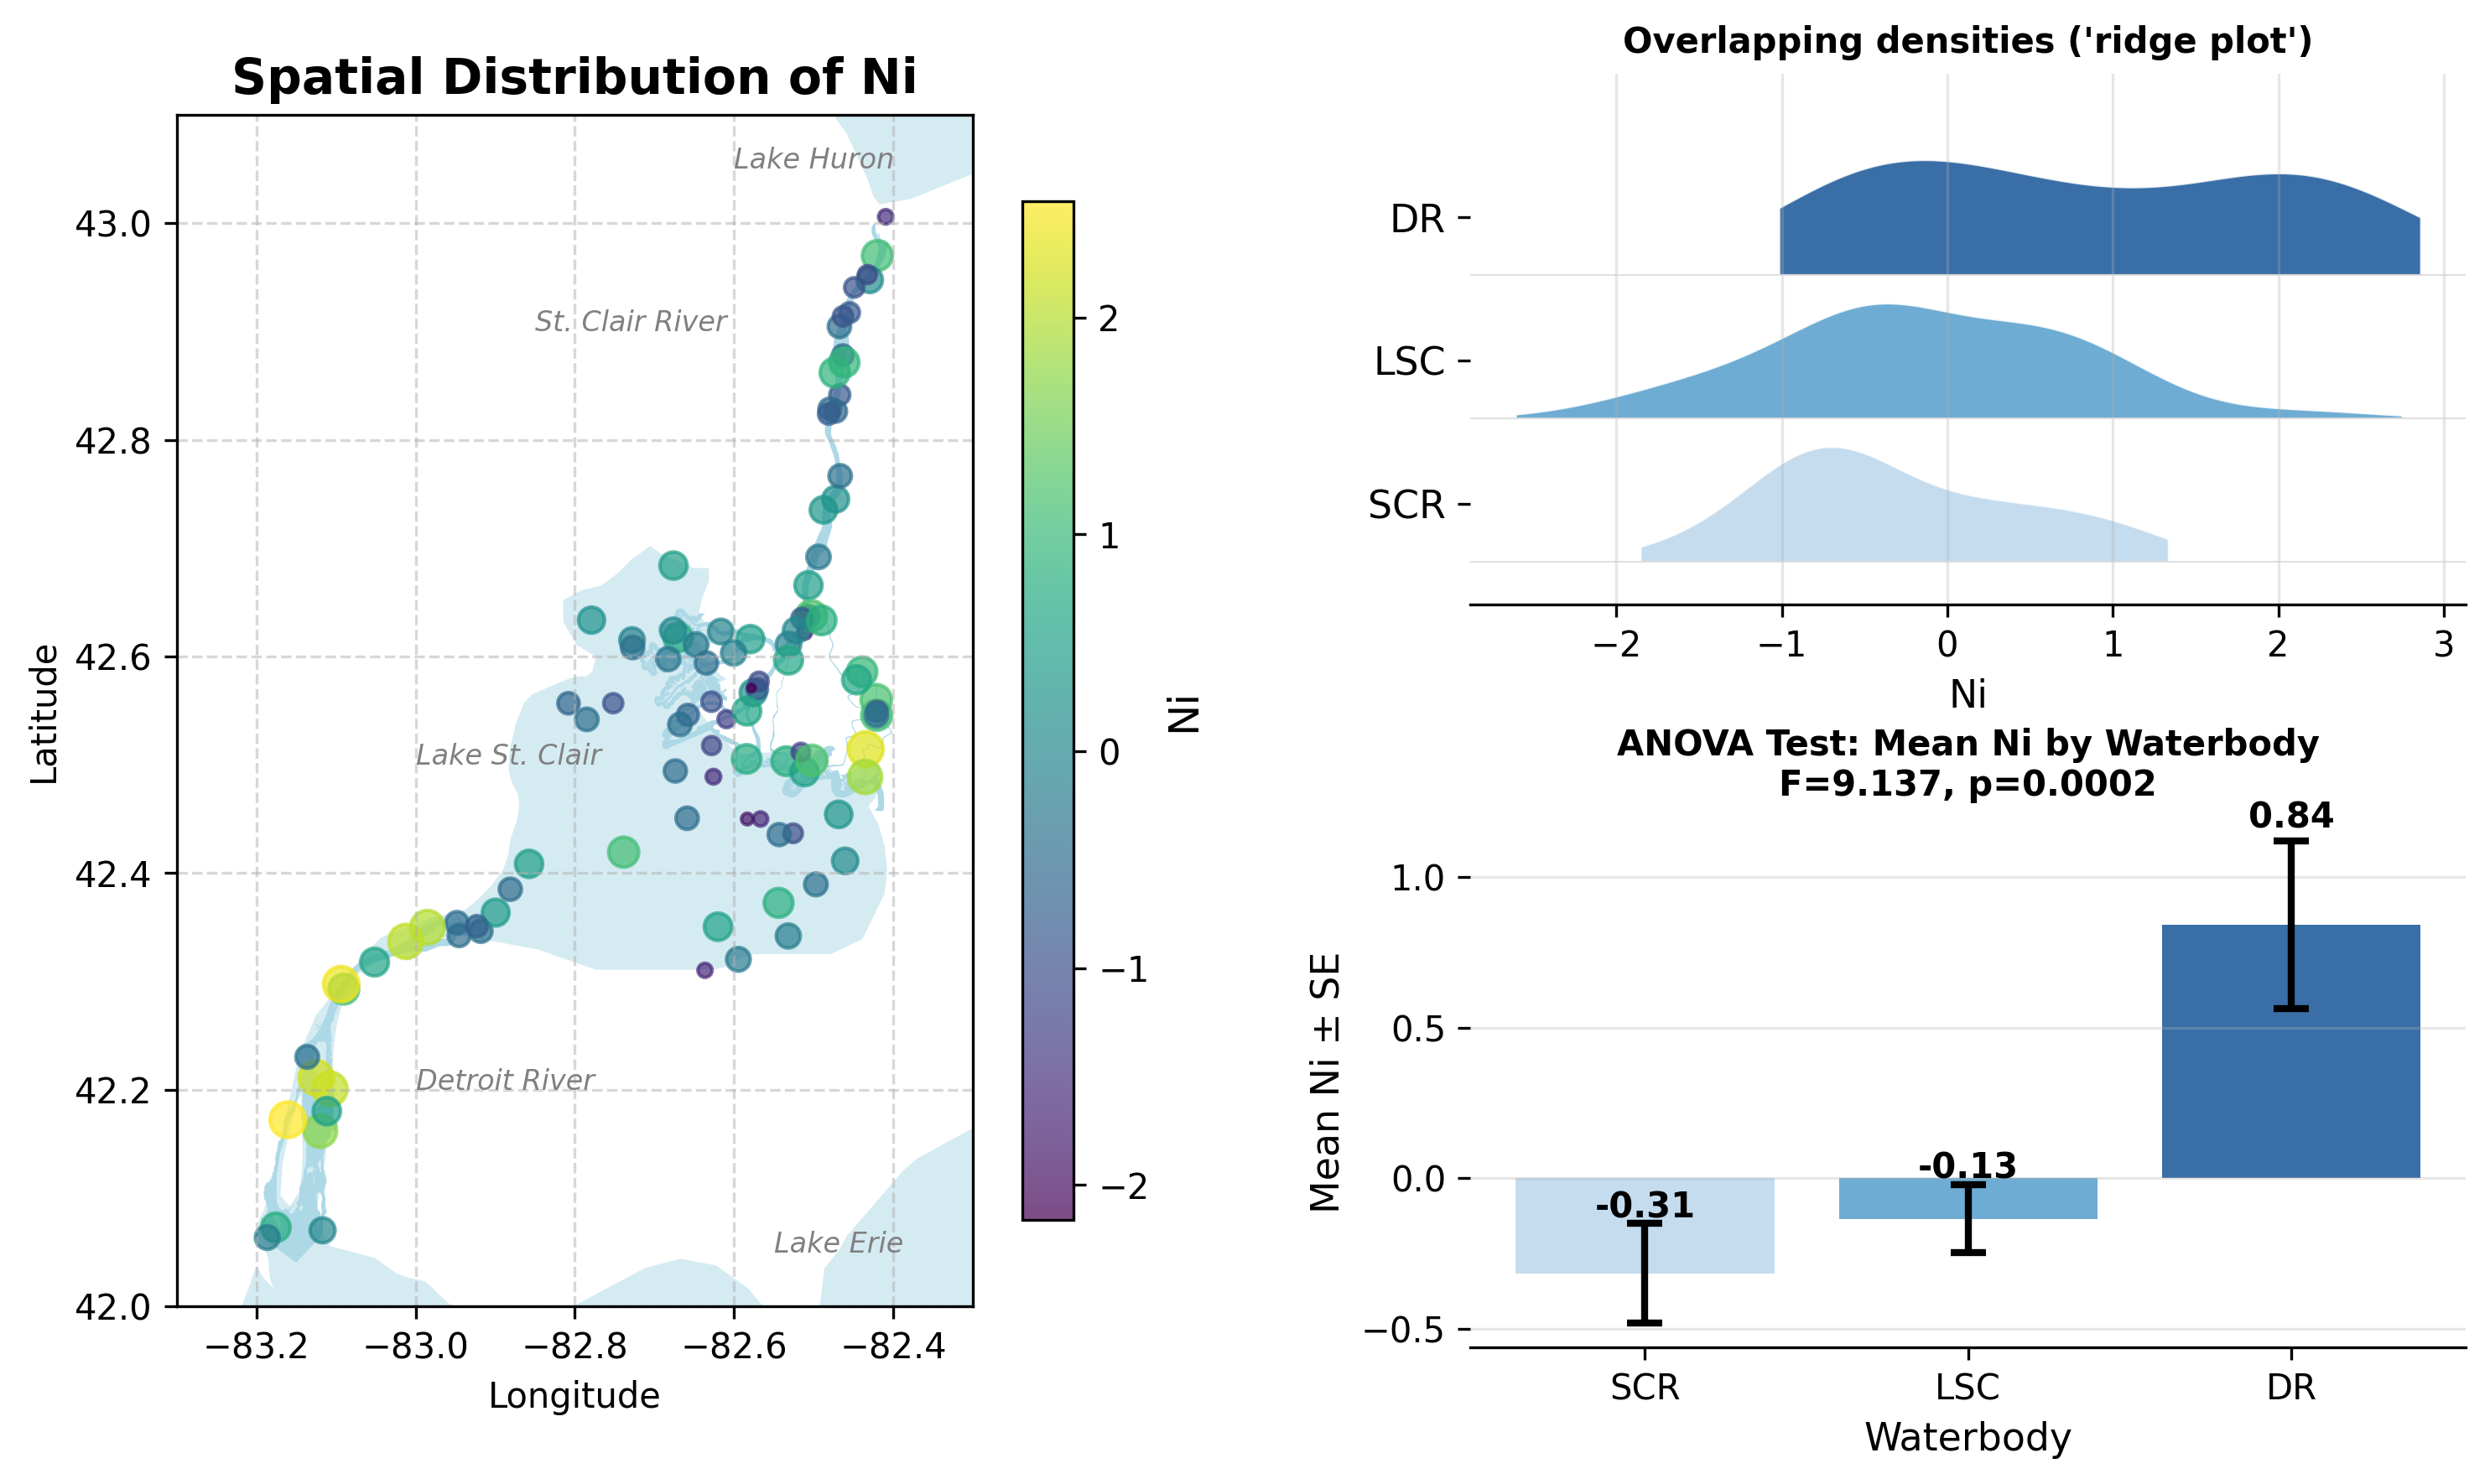

In [47]:
# check the spatial distribution of Ni after z-scoring
feature_name = "Ni"
# add the location to the pollution data for plotting
fig, f_stat, p_value = plot_feature_analysis(zscored_log_pollution, feature_name)